# 1) 데이터 준비와 확인

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import tensorflow as tf
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [2]:
print('훈련용 리뷰 개수 :',len(train_data))
print('테스트용 리뷰 개수 :',len(test_data))

훈련용 리뷰 개수 : 150000
테스트용 리뷰 개수 : 50000


In [3]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    # 사전 word to index 구성
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    #텍스트를 사전 인덱스로 바꾸기 
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data, num_words=10000)

In [4]:
# X_train,X_test,y_train,y_test, word_to_index=load_data(train_data, test_data, num_words=10000)
X_train[:4]

[[32, 74, 919, 4, 4, 39, 228, 20, 33, 748],
 [1028, 4, 11, 519, 549, 687, 5, 120, 4, 70, 1639, 52, 925, 1006, 15, 44, 391],
 [24, 205, 2],
 [8409, 158, 3925, 4, 4, 298, 94, 17, 6, 4, 4, 58, 3479]]

In [5]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [6]:
#텍스트 데이터를 숫자로 바꾸기
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

** 임베딩 레이어 등장!!

# 3. 모델 구성을 위한 데이터 분석 및 가공
## 3-1) 데이터셋 내 길이 분포

In [7]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [8]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092


리뷰의 최대 길이 : 116
리뷰의 평균 길이 : 15.96940191154864


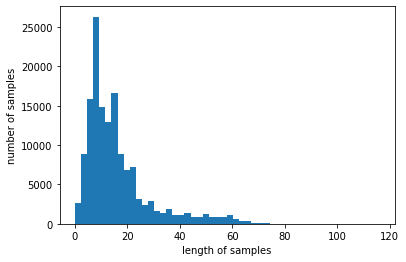

In [9]:
print('리뷰의 최대 길이 :', np.max(num_tokens))
print('리뷰의 평균 길이 :', np.mean(num_tokens))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

## 3-2) 적절한 최대 문장 길이 지정

In [10]:
# 최대 길이를 41로 지정하면 93%이상을 포함한다.
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_len = int(max_tokens)
print('pad_sequences maxlen : ', max_len)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


## 3-3) keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [11]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train,
                       maxlen = max_len,
                       value=word_to_index['<PAD>'],
                       padding='pre')
X_test = pad_sequences(X_test,
                      maxlen = max_len,
                      value=word_to_index['<PAD>'],
                      padding='pre')

In [12]:
print(X_train.shape)
print(X_test.shape)

(146182, 41)
(49157, 41)


# 4. 모델구성 및 validation set 구성

In [13]:
#RNN
vocab_size = 10000
word_vector_dim = 16

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 64로 하였습니다. (변경가능)
model.add(keras.layers.Dense(8, activation='relu')) # 안해도 됨
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


# 데이터셋 분리

In [14]:
# validation set 29300건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


# 모델훈련

In [15]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [16]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512, # 512, 100 
                    validation_data=(X_val, y_val),
                    verbose=1,
                    callbacks = [es, mc])

Epoch 1/20
266/266 [==============================] - 5s 14ms/step - loss: 0.6231 - accuracy: 0.6482 - val_loss: 0.3949 - val_accuracy: 0.8408
Epoch 2/20
266/266 [==============================] - 3s 12ms/step - loss: 0.3618 - accuracy: 0.8530 - val_loss: 0.3511 - val_accuracy: 0.8447
Epoch 3/20
266/266 [==============================] - 3s 12ms/step - loss: 0.3195 - accuracy: 0.8691 - val_loss: 0.3386 - val_accuracy: 0.8521
Epoch 4/20
266/266 [==============================] - 3s 13ms/step - loss: 0.3036 - accuracy: 0.8728 - val_loss: 0.3373 - val_accuracy: 0.8505
Epoch 5/20
266/266 [==============================] - 3s 13ms/step - loss: 0.2938 - accuracy: 0.8774 - val_loss: 0.3365 - val_accuracy: 0.8527
Epoch 6/20
266/266 [==============================] - 4s 14ms/step - loss: 0.2841 - accuracy: 0.8810 - val_loss: 0.3403 - val_accuracy: 0.8512
Epoch 7/20
266/266 [==============================] - 3s 13ms/step - loss: 0.2787 - accuracy: 0.8821 - val_loss: 0.3509 - val_accuracy: 0.8503

## Loss, Accuracy 그래프 시각화

In [17]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3718 - accuracy: 0.8467
[0.3718127906322479, 0.8467156291007996]


In [18]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


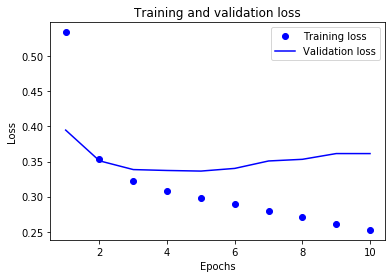

In [19]:

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

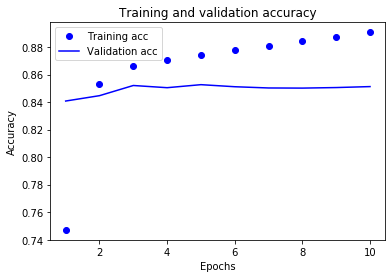

In [20]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 학습된 EMBEDDING 레이어 분석

In [21]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


* 한국어 WORD 2VEC

In [58]:
import os # new
from pathlib import Path

In [59]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

# 한국어 워드투백터 임베딩 활용해서 성능개선
** 이부분은 마감시간이 얼마 안남았는데 gensim 설치가 오래 걸려서 못했습니다.
설치 후에 해볼 예정이에요 

In [61]:
from gensim.models import KeyedVectors
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
vector = word2vec['computer']

ModuleNotFoundError: No module named 'gensim'

# CNN에 임베딩 벡터 적용

In [24]:
# * Cnn 모델
vocab_size = 10000
word_vector_dim = 4

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 4)           40000     
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          464       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [25]:
# validation set 29300건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


In [26]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [27]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512, # 512, 100 
                    validation_data=(X_val, y_val),
                    verbose=1,
                    callbacks = [es, mc])

Epoch 1/20
266/266 [==============================] - 1s 4ms/step - loss: 0.6275 - accuracy: 0.6056 - val_loss: 0.3645 - val_accuracy: 0.8411
Epoch 2/20
266/266 [==============================] - 1s 4ms/step - loss: 0.3432 - accuracy: 0.8516 - val_loss: 0.3400 - val_accuracy: 0.8535
Epoch 3/20
266/266 [==============================] - 1s 3ms/step - loss: 0.3156 - accuracy: 0.8669 - val_loss: 0.3361 - val_accuracy: 0.8536
Epoch 4/20
266/266 [==============================] - 1s 4ms/step - loss: 0.2959 - accuracy: 0.8754 - val_loss: 0.3366 - val_accuracy: 0.8522
Epoch 5/20
266/266 [==============================] - 1s 4ms/step - loss: 0.2859 - accuracy: 0.8828 - val_loss: 0.3388 - val_accuracy: 0.8523
Epoch 6/20
266/266 [==============================] - 1s 4ms/step - loss: 0.2736 - accuracy: 0.8888 - val_loss: 0.3408 - val_accuracy: 0.8505
Epoch 7/20
266/266 [==============================] - 1s 3ms/step - loss: 0.2610 - accuracy: 0.8947 - val_loss: 0.3470 - val_accuracy: 0.8484
Epoch 

In [46]:
#시각화
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 0s - loss: 0.4993 - accuracy: 0.7636
[0.49934816360473633, 0.7635535001754761]


In [29]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


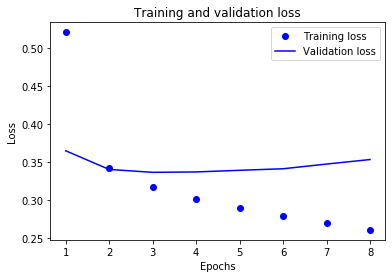

In [30]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

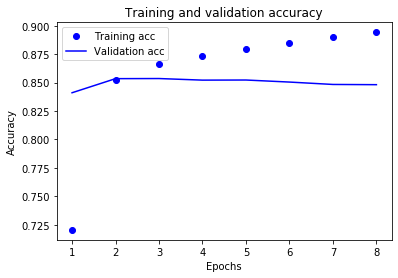

In [31]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# GlobalMaxPooling1D() 사용
#전체 문장 중 가장 중요한 단어만 특징으로 추출하여 문장의 긍정/부정을 평가하는 방식

In [47]:
vocab_size = 10000
word_vector_dim = 4
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 4)           40000     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 4)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 40,049
Trainable params: 40,049
Non-trainable params: 0
_________________________________________________________________


In [39]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [40]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512, # 512, 100 
                    validation_data=(X_val, y_val),
                    verbose=1,
                    callbacks = [es, mc])

Epoch 1/20
266/266 [==============================] - 1s 2ms/step - loss: 0.6706 - accuracy: 0.6164 - val_loss: 0.5610 - val_accuracy: 0.7402
Epoch 2/20
266/266 [==============================] - 1s 2ms/step - loss: 0.5373 - accuracy: 0.7431 - val_loss: 0.5023 - val_accuracy: 0.7621
Epoch 3/20
266/266 [==============================] - 0s 2ms/step - loss: 0.4893 - accuracy: 0.7684 - val_loss: 0.4952 - val_accuracy: 0.7652
Epoch 4/20
266/266 [==============================] - 0s 2ms/step - loss: 0.4743 - accuracy: 0.7748 - val_loss: 0.4944 - val_accuracy: 0.7659
Epoch 5/20
266/266 [==============================] - 1s 2ms/step - loss: 0.4681 - accuracy: 0.7767 - val_loss: 0.4955 - val_accuracy: 0.7639
Epoch 6/20
266/266 [==============================] - 1s 2ms/step - loss: 0.4616 - accuracy: 0.7821 - val_loss: 0.4966 - val_accuracy: 0.7633
Epoch 7/20
266/266 [==============================] - 0s 2ms/step - loss: 0.4583 - accuracy: 0.7823 - val_loss: 0.4982 - val_accuracy: 0.7622
Epoch 

In [41]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 0s - loss: 0.4993 - accuracy: 0.7636
[0.49934816360473633, 0.7635535001754761]


In [42]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


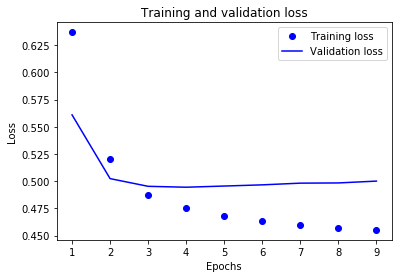

In [43]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

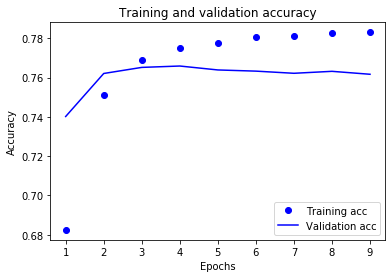

In [44]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 회고
1. 가장 많은 오류를 만난 프로젝트였다. 처음에 로드데이터 짜는거부터 막막했다. 어디서부터 참고해야할지 몰라서 한참을 헤맸다.
2. 시간을 많이들였는데 완전히 성취하지 못해서 아쉽다..
3. 오류를 해결하기에 급급해서 모델 정확도나 다양한 방법으로 시도하지 못해봐서 아쉽다.
4. 그래도 한번 고생해서 하고나니 전체적인 흐름은 파악이 됐고 전처리를 경험해봐서 의미있었다.

** 정신없이 하느라 프로젝트 정리를 깔끔하게 못했네요ㅠㅠ